In [ ]:
# 🔥 Úplné odstránenie nekompatibilných verzií
!pip uninstall -y transformers huggingface-hub tokenizers sentence-transformers peft

# 🧹 (ak máš oprávnenie) Vyčistenie cache
!rm -rf /root/.cache/huggingface

# ✅ Inštalácia stabilných verzií, ktoré sú 100 % kompatibilné s Trainer
!pip install transformers==4.40.1 huggingface-hub==0.30.2 tokenizers==0.19.1


In [35]:
# 🧮 Vyhodnocovacia funkcia – metriky pre binárnu klasifikáciu
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "eval_accuracy": accuracy_score(labels, preds),
        "eval_precision": precision_score(labels, preds),
        "eval_recall": recall_score(labels, preds),
        "eval_f1": f1_score(labels, preds)  # kľúčové pre F1 graf a výber najlepšieho modelu
    }


In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [4]:
# 📥 Načítanie datasetu FredZhang7/toxi-text-3M (len SK a EN)
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Načítame celý dataset a ponecháme iba jazyky sk + en
ds = load_dataset("FredZhang7/toxi-text-3M", split="train", verification_mode="no_checks")
df = ds.to_pandas()
df = df[df["lang"].isin(["sk", "en"])].reset_index(drop=True)

# ➕ Pridáme binárny label
df["label"] = df["is_toxic"]

# 🔁 Stratifikovaný výber 20 000 komentárov (rovnaké ako pri ToxicBERT)
df_sample, _ = train_test_split(df, train_size=20000, stratify=df["label"], random_state=42)

# 📊 Rozdelenie na train / val / test (80 / 10 / 10) stratifikovane
train_df, temp_df = train_test_split(df_sample, test_size=0.2, stratify=df_sample["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# 💾 Uloženie CSV
train_df.to_csv("train_multilingual.csv", index=False)
val_df.to_csv("val_multilingual.csv", index=False)
test_df.to_csv("test_multilingual.csv", index=False)

print("✅ Stratifikovaný výber a rozdelenie hotové:")
print("Train:", train_df.shape, "| Val:", val_df.shape, "| Test:", test_df.shape)


multilingual-train-deduplicated.csv:  54%|#####4    | 786M/1.45G [00:00<?, ?B/s]

multilingual-validation%28new%29.csv:   0%|          | 0.00/9.07M [00:00<?, ?B/s]

multilingual-test.csv:   0%|          | 0.00/28.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2880667 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29641 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/63812 [00:00<?, ? examples/s]

✅ Stratifikovaný výber a rozdelenie hotové:
Train: (16000, 4) | Val: (2000, 4) | Test: (2000, 4)


In [5]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


In [36]:
checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True).remove_columns(["text", "lang"])
valid_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True).remove_columns(["text", "lang"])
test_ds = Dataset.from_pandas(test_df).map(tokenize, batched=True).remove_columns(["text", "lang"])

train_ds = train_ds.rename_column("label", "labels")
valid_ds = valid_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [37]:
training_losses = []
validation_losses = []
eval_accuracies = []
epochs_logged = []

class EpochMetricsTracker(TrainerCallback):
    def __init__(self):
        self.last_logged_epoch = -1

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs and 'epoch' in logs:
            epoch = int(logs['epoch'])
            if epoch != self.last_logged_epoch:
                training_losses.append(logs['loss'])
                self.last_logged_epoch = epoch

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            if 'eval_loss' in metrics:
                validation_losses.append(metrics['eval_loss'])
            if 'eval_accuracy' in metrics:
                eval_accuracies.append(metrics['eval_accuracy'])
            epochs_logged.append(int(state.epoch))


In [39]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=7,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    logging_dir="./logs",
    logging_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EpochMetricsTracker(), EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.070300,0.654058,0.868000,0.466042,0.846809,0.601208
2,0.065200,0.417818,0.922500,0.657480,0.710638,0.683027
3,0.038000,0.437546,0.936500,0.796703,0.617021,0.695444
4,0.052500,0.468910,0.930500,0.726415,0.655319,0.689038
5,0.025400,0.515053,0.926000,0.683544,0.689362,0.686441


TrainOutput(global_step=5000, training_loss=0.050279621887207034, metrics={'train_runtime': 1243.5153, 'train_samples_per_second': 90.067, 'train_steps_per_second': 5.629, 'total_flos': 5262221107200000.0, 'train_loss': 0.050279621887207034, 'epoch': 5.0})

In [40]:
from datasets import Dataset
checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)
test_ds = Dataset.from_pandas(test_df).map(tokenize, batched=True)

for ds in [train_ds, val_ds, test_ds]:
    ds = ds.rename_column("label", "labels")
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [41]:
# ✅ Vyhodnotenie binárneho XLM-RoBERTa modelu
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_auc_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Predikcia na testovacej množine
preds_output = trainer.predict(test_ds)
labels = preds_output.label_ids
preds = np.argmax(preds_output.predictions, axis=1)
probs = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1)[:, 1].numpy()

# Výstupný priečinok
os.makedirs("results", exist_ok=True)

# Klasifikačný report - TXT
report = classification_report(labels, preds, target_names=["Non-toxic", "Toxic"], digits=4)
with open("results/classification_report.txt", "w") as f:
    f.write(report)

# Klasifikačný report - CSV
report_dict = classification_report(labels, preds, target_names=["Non-toxic", "Toxic"], digits=4, output_dict=True)
pd.DataFrame(report_dict).transpose().to_csv("results/classification_report_full.csv")

# MCC
mcc = matthews_corrcoef(labels, preds)
print("Matthews Correlation Coefficient (MCC):", round(mcc, 4))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("results/confusion_matrix.png")
plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = roc_auc_score(labels, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color="darkorange")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/roc_curve.png")
plt.close()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(labels, probs)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("results/pr_curve.png")
plt.close()


Matthews Correlation Coefficient (MCC): 0.6502


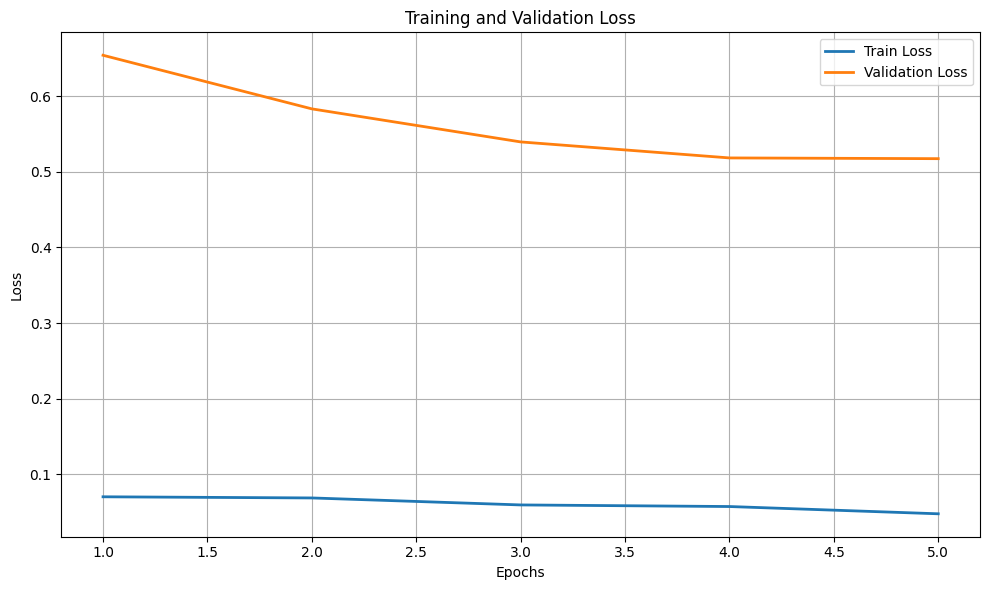

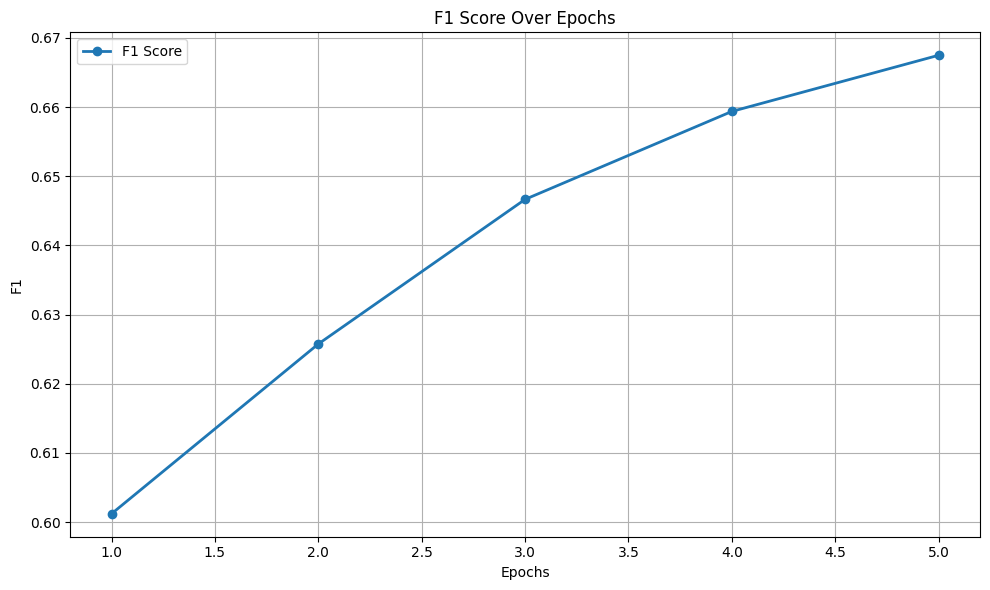

In [43]:
# 📉 Tréningové metriky (Loss, F1) – ak dostupné
epoch_logs = [x for x in trainer.state.log_history if "epoch" in x and "eval_loss" in x]
train_loss_epoch = [x["loss"] for x in trainer.state.log_history if "loss" in x and "epoch" in x]
val_loss_epoch = [x["eval_loss"] for x in epoch_logs]
f1_epoch = [x["eval_f1"] for x in epoch_logs if "eval_f1" in x]
epochs = [x["epoch"] for x in epoch_logs]

def smooth(values, alpha=0.3):
    if not values:
        return []
    smoothed = []
    last = values[0]
    for v in values:
        smoothed_val = alpha * v + (1 - alpha) * last
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

if train_loss_epoch and val_loss_epoch:
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, smooth(train_loss_epoch), label="Train Loss", linewidth=2)
    plt.plot(epochs, smooth(val_loss_epoch), label="Validation Loss", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("results/loss_clean_graph.png")
    plt.show()

if f1_epoch:
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, smooth(f1_epoch), marker='o', label="F1 Score", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("F1")
    plt.title("F1 Score Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("results/accuracy_graph.png")
    plt.show()


In [44]:
import zipfile

with zipfile.ZipFile("final_results_multilingual.zip", "w") as zipf:
    for file in os.listdir("results"):
        zipf.write(os.path.join("results", file), arcname=file)
print("✅ Výstupy boli zozipované.")


✅ Výstupy boli zozipované.
